# Toy Problem

This jupyter notebook demonstrates the use of the *johnstondechazal* method to determine the optimum ground truth landmark position using a toy problem given a number of ground truth annotations as provided by *expert*, *crowd sourced* and *adversarial* annotators.  In this toy problem each annotator has been asked to identify the location of a single described co-ordinate in a 2D space, three different times.  The *expert* annotators, the higher performing of the group are able to more accurately identify the landmark with greater precision each time, the crowd sourced annotators are less precise in their selections as well as have a poorer understanding of the location of the described landmark.  The *adversarial* annotators, are those who aren't interested in the quality of the completed task but are simply wanting to complete it to obtain the desired incentive; as such their selections are essentially random with no consideration to the requirements of the task.

For the task of annotating ground truth data there is some overall ground truth position $Y_G$ for the problem, though its precise position is unknown by all annotators.  Each group of annotators are able to estimate this position with some deviation, with the *experts* being more likely to determine $Y_G$ and the *adversarial* annotators the least.  Additionally there is some variance for each group in the landmark selected for each independent repetition, again the *experts* having the least amount of variance per selection.

In this notebook we will compare the performance of the *johnstondechazal* method in estimating $Y_G$ compared with simply taking the average value of all selections.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

from johnstondechazal import FindGrouthTruth
from johnstondechazal.visualise import plot_history

##### Setup of the Problem #####

# Number of Annotators
A_EXPERTS = 4
A_CROWD = 10
A_ADVERSARIAL = 2

# Replicates
R = 3

# Dimensions
D = 2

# Unknown ground truth value
Y_G = (20, 30)

##### Precision and Variance Selection #####
# Experts
Y_G_EXPERTS = (-2, 4)
EXPERTS_SIGMA = (1, 11)

# Crowd Sourced Workers
Y_G_CROWD = (-6, 8)
CROWD_SIGMA = (1, 15)

# Adversarial Annotators
Y_G_ADV = (60, 90)
ADV_SIGMA = (10, 20)

rng = np.random.default_rng(12345)


## Experts Selections

The following section generates the presents the data if only considering the selections made by the *expert* group.

In [2]:
# Create a sample of annotators
annotators_dist = np.zeros((A_EXPERTS, R, 2))
for i in range(A_EXPERTS):
    annot_mean = Y_G + rng.integers(Y_G_EXPERTS[0], Y_G_EXPERTS[1], size=(1, 2)) + rng.random(size=(1, 2))
    annot_sigma = rng.integers(EXPERTS_SIGMA[0], EXPERTS_SIGMA[1], size=(1, 2)) + rng.random(size=(1, 2))
    annot_dist = np.array(annot_mean) + rng.choice([-1, 1], size=(R, 2)) * np.array(annot_sigma) * rng.random((R, 2))
    annotators_dist[i] = annot_dist

    print(f'Annotator {i}: mean = {annotators_dist[i].mean(axis=0)}, sigma = {annotators_dist[i].std(axis=0)}')
    
annotators_dist = np.array(annotators_dist)

Annotator 0: mean = [22.06305549 29.85321199], sigma = [5.71403327 3.54683906]
Annotator 1: mean = [18.57550046 29.16764795], sigma = [0.42064233 2.31461008]
Annotator 2: mean = [23.94364862 35.49639484], sigma = [5.06586373 2.76471492]
Annotator 3: mean = [19.24813588 30.05651161], sigma = [0.54833047 0.40941436]


In [3]:
meta = {'workerid': [i for i in range(A_EXPERTS)], 'type': A_EXPERTS * ['worker']}

meta = pd.DataFrame.from_dict(meta)  
gt = FindGrouthTruth()
history = gt.converge_select(annotators_dist, meta)

Plot all the landmarks with the ground truth location, the global mean and the *johnstondechazal* localisation.

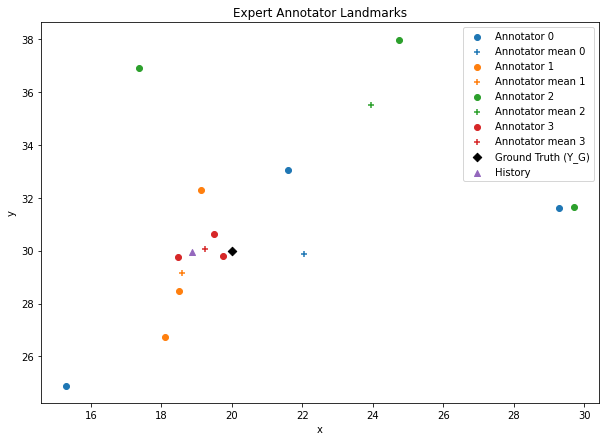

In [4]:
fig, ax = plt.subplots(figsize=(10, 7))
for i in range(A_EXPERTS):
    
    points = ax.scatter(annotators_dist[i, :, 0], annotators_dist[i, :, 1], label=f'Annotator {i}')
    _mu = annotators_dist[i].mean(axis=0)
    plt.scatter(_mu[0], _mu[1], c=points.get_facecolor(), marker='+', label=f'Annotator mean {i}')
    
ax.scatter(Y_G[0], Y_G[1], label='Ground Truth (Y_G)', c='k', marker='D')
_mean = annotators_dist.reshape((-1, 2)).mean(axis=0)

ax.scatter(history.loc[0], history.loc[1], marker='^', label='History')
plt.legend();
plt.title('Expert Annotator Landmarks');
plt.xlabel('x');
plt.ylabel('y');

How does the ground truth estimate change over the iterations of the procedure?

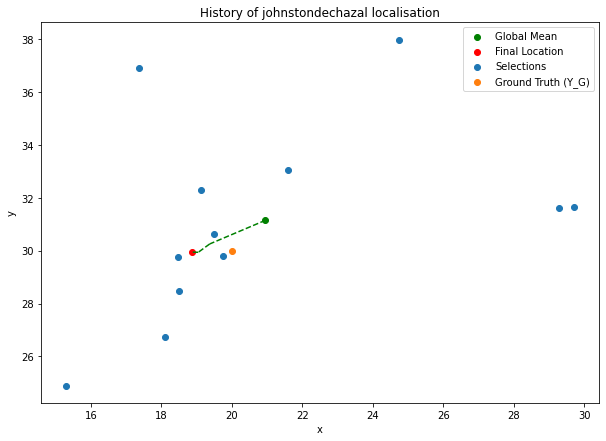

In [5]:
_y = annotators_dist.reshape((-1, 2))
fig, ax = plt.subplots(figsize=(10, 7))

plot_history(history, ax, c=['g', 'r']) # Pass the history object
ax.scatter(_y[:,0], _y[:,1], label='Selections'); # Plot the initial values
ax.scatter(Y_G[0], Y_G[1], label='Ground Truth (Y_G)'); # Plot the ground truth

plt.title('History of johnstondechazal localisation');
plt.legend();
plt.xlabel('x');
plt.ylabel('y');

In [6]:
mean_dist = euclidean(Y_G, _mean)
print(f'Euclidean distance between ground truth mean {Y_G} and global mean {_mean} = {mean_dist: .2f}')
history_dist = euclidean(Y_G, history.loc)
print(f'Euclidean distance between ground truth mean {Y_G} and johnstondechazal mean {history.loc} = {history_dist: .2f}')

Euclidean distance between ground truth mean (20, 30) and global mean [20.95758512 31.1434416 ] =  1.49
Euclidean distance between ground truth mean (20, 30) and johnstondechazal mean [18.85786481 29.94135555] =  1.14


## Crowd Sourced Workers

In [7]:
# Create a sample of annotators
annotators_dist_crowd = np.zeros((A_EXPERTS + A_CROWD, R, 2))
annotators_dist_crowd[:A_EXPERTS] = annotators_dist

for i in range( A_CROWD):
    annot_mean = Y_G + rng.integers(Y_G_CROWD[0], Y_G_CROWD[1], size=(1, 2)) + rng.random(size=(1, 2))
    annot_sigma = rng.integers(CROWD_SIGMA[0], CROWD_SIGMA[1], size=(1, 2)) + rng.random(size=(1, 2))
    annot_dist = np.array(annot_mean) + rng.choice([-1, 1], size=(R, 2)) * np.array(annot_sigma) * rng.random((R, 2))
    annotators_dist_crowd[A_EXPERTS + i] = annot_dist

    print(f'Adversarial annotator {i}: mean = {annotators_dist_crowd[A_EXPERTS + i].mean(axis=0)}, sigma = {annotators_dist_crowd[A_EXPERTS + i].std(axis=0)}')

Adversarial annotator 0: mean = [24.68542064 25.30851717], sigma = [2.1343272  2.02543499]
Adversarial annotator 1: mean = [27.90972564 29.86402741], sigma = [1.64405819 4.32381157]
Adversarial annotator 2: mean = [15.54165918 25.1543551 ], sigma = [3.64036161 8.05053728]
Adversarial annotator 3: mean = [28.3251275  29.33074868], sigma = [1.50745172 2.82033825]
Adversarial annotator 4: mean = [16.64125473 26.67736674], sigma = [2.8968472  5.84267304]
Adversarial annotator 5: mean = [16.07544578 33.07417142], sigma = [1.35091957 6.76537641]
Adversarial annotator 6: mean = [26.3012897 31.9336381], sigma = [7.46675588 0.65817604]
Adversarial annotator 7: mean = [20.4092587  33.24932497], sigma = [0.56431743 2.58046637]
Adversarial annotator 8: mean = [20.93559609 30.51923344], sigma = [3.48205763 7.56805611]
Adversarial annotator 9: mean = [17.80551422 27.59863603], sigma = [0.71154645 3.37042839]


In [8]:
meta = {'workerid': [i for i in range(A_EXPERTS + A_CROWD)], 'type': A_EXPERTS * ['worker'] + A_CROWD * ['crowd']}

meta = pd.DataFrame.from_dict(meta)  
gt = FindGrouthTruth()
history = gt.converge_select(annotators_dist_crowd, meta)

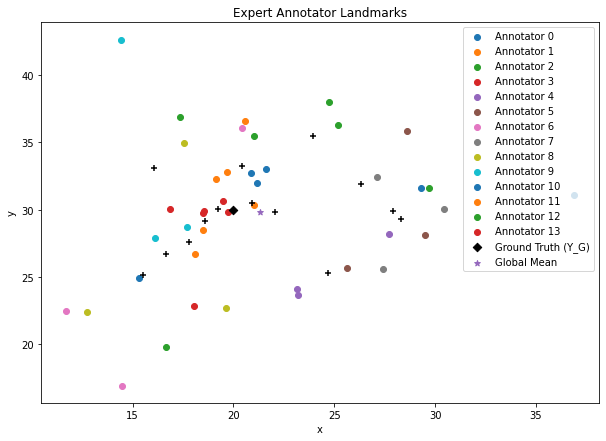

In [9]:
plt.figure(figsize=(10, 7))
for i in range(A_EXPERTS + A_CROWD):
    
    plt.scatter(annotators_dist_crowd[i, :, 0], annotators_dist_crowd[i, :, 1], label=f'Annotator {i}')
    _mu = annotators_dist_crowd[i].mean(axis=0)
    plt.scatter(_mu[0], _mu[1], c='k', marker='+')
    
plt.scatter(Y_G[0], Y_G[1], label='Ground Truth (Y_G)', c='k', marker='D')
_mean = annotators_dist_crowd.reshape((-1, 2)).mean(axis=0)
plt.scatter(_mean[0], _mean[1], marker='*', label='Global Mean')
ax.scatter(history.loc[0], history.loc[1], marker='^', label='History')
plt.legend();
plt.title('Expert Annotator Landmarks');
plt.xlabel('x');
plt.ylabel('y');

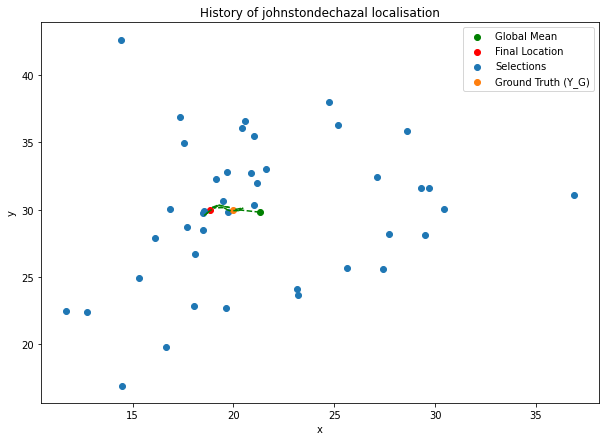

In [10]:
_y = annotators_dist_crowd.reshape((-1, 2))
fig, ax = plt.subplots(figsize=(10, 7))

plot_history(history, ax, c=['g', 'r']) # Pass the history object
ax.scatter(_y[:,0], _y[:,1], label='Selections'); # Plot the initial values
ax.scatter(Y_G[0], Y_G[1], label='Ground Truth (Y_G)'); # Plot the ground truth

plt.title('History of johnstondechazal localisation');
plt.legend();
plt.xlabel('x');
plt.ylabel('y');

In [11]:
mean_dist = euclidean(Y_G, _mean)
print(f'Euclidean distance between ground truth mean {Y_G} and global mean {_mean} = {mean_dist: .2f}')
history_dist = euclidean(Y_G, history.loc)
print(f'Euclidean distance between ground truth mean {Y_G} and johnstondechazal mean {history.loc} = {history_dist: .2f}')

Euclidean distance between ground truth mean (20, 30) and global mean [21.31861662 29.80598468] =  1.33
Euclidean distance between ground truth mean (20, 30) and johnstondechazal mean [18.85786481 29.94135555] =  1.14


## Adversarial Mean

In [12]:
# Create a sample of annotators
annotators_dist_adv = np.zeros((A_EXPERTS + A_CROWD + A_ADVERSARIAL, R, 2))
annotators_dist_adv[:A_EXPERTS + A_CROWD] = annotators_dist_crowd

for i in range(A_ADVERSARIAL):
    annot_mean = Y_G + rng.integers(Y_G_ADV[0], Y_G_ADV[1], size=(1, 2)) + rng.random(size=(1, 2))
    annot_sigma = rng.integers(ADV_SIGMA[0], ADV_SIGMA[1], size=(1, 2)) + rng.random(size=(1, 2))
    annot_dist = np.array(annot_mean) + rng.choice([-1, 1], size=(R, 2)) * np.array(annot_sigma) * rng.random((R, 2))
    annotators_dist_adv[A_EXPERTS + A_CROWD + i] = annot_dist

    print(f'Adversarial annotator {i}: mean = {annotators_dist_adv[A_EXPERTS + A_CROWD + i].mean(axis=0)}, sigma = {annotators_dist_adv[A_EXPERTS + A_CROWD + i].std(axis=0)}')
    

Adversarial annotator 0: mean = [ 86.69354321 104.63815207], sigma = [3.29624198 6.34352343]
Adversarial annotator 1: mean = [103.89528983 122.48249545], sigma = [7.31235143 9.27370949]


In [13]:
meta = {'workerid': [i for i in range(A_EXPERTS + A_CROWD + A_ADVERSARIAL)], 'type': A_EXPERTS * ['worker'] + A_CROWD * ['crowd'] + A_ADVERSARIAL * ['adversarial']}

meta = pd.DataFrame.from_dict(meta)  
gt = FindGrouthTruth()
history = gt.converge_select(annotators_dist_adv, meta)

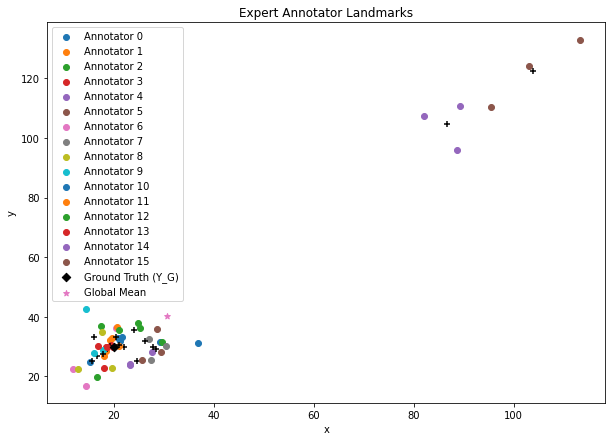

In [14]:
plt.figure(figsize=(10, 7))
for i in range(A_EXPERTS + A_CROWD + A_ADVERSARIAL):
    
    plt.scatter(annotators_dist_adv[i, :, 0], annotators_dist_adv[i, :, 1], label=f'Annotator {i}')
    _mu = annotators_dist_adv[i].mean(axis=0)
    plt.scatter(_mu[0], _mu[1], c='k', marker='+')
    
plt.scatter(Y_G[0], Y_G[1], label='Ground Truth (Y_G)', c='k', marker='D')
_mean = annotators_dist_adv.reshape((-1, 2)).mean(axis=0)
plt.scatter(_mean[0], _mean[1], marker='*', label='Global Mean')
ax.scatter(history.loc[0], history.loc[1], marker='^', label='History')
plt.legend();
plt.title('Expert Annotator Landmarks');
plt.xlabel('x');
plt.ylabel('y');

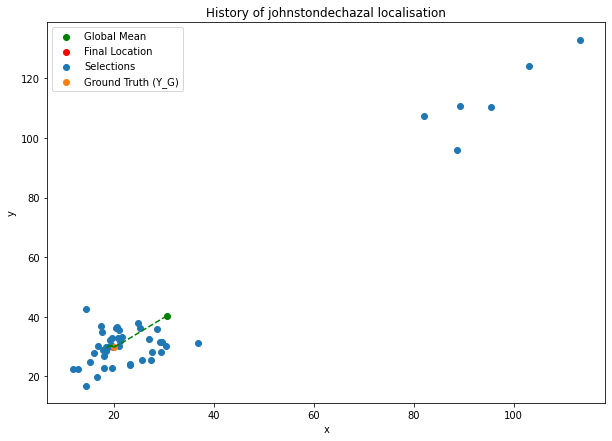

In [15]:
_y = annotators_dist_adv.reshape((-1, 2))
fig, ax = plt.subplots(figsize=(10, 7))

plot_history(history, ax, c=['g', 'r']) # Pass the history object
ax.scatter(_y[:,0], _y[:,1], label='Selections'); # Plot the initial values
ax.scatter(Y_G[0], Y_G[1], label='Ground Truth (Y_G)'); # Plot the ground truth

plt.title('History of johnstondechazal localisation');
plt.legend();
plt.xlabel('x');
plt.ylabel('y');

In [16]:
mean_dist = euclidean(Y_G, _mean)
print(f'Euclidean distance between ground truth mean {Y_G} and global mean {_mean} = {mean_dist: .2f}')
history_dist = euclidean(Y_G, history.loc)
print(f'Euclidean distance between ground truth mean {Y_G} and johnstondechazal mean {history.loc} = {history_dist: .2f}')

Euclidean distance between ground truth mean (20, 30) and global mean [30.5655916  40.27527706] =  14.74
Euclidean distance between ground truth mean (20, 30) and johnstondechazal mean [18.85786481 29.94135555] =  1.14
